### Importing Libraries

In [3]:
pip install elasticdeform
pip install wandb

Note: you may need to restart the kernel to use updated packages.


In [2]:
import torch, elasticdeform
import torch.nn as nn
import torch.nn.functional as F

import numpy as np
import matplotlib.pyplot as plt

from torch.utils.data import Dataset, DataLoader

import torchvision.transforms as transforms
import torchvision.transforms.functional as TF

import torch.optim as optim

import os

from PIL import Image, ImageOps

import random,wandb

### Defining the Dataset Class

In [49]:
class Cell_data(Dataset):
  def __init__(self, data_dir, size, train = True, train_test_split = 0.8, augment_data = True):
    super(Cell_data, self).__init__()
    
    self.data_dir = data_dir
    self.size = size
    self.train = train
    self.train_test_split = train_test_split
    self.augment_data = augment_data
    self.image_filepath = self.data_dir+'/'+"scans/"
    self.label_filepath = self.data_dir+'/'+"labels/"
    self.filepaths = os.listdir(self.image_filepath)   
    random.shuffle(self.filepaths)   
    self.train_filepaths = self.filepaths[:int(len(self.filepaths)*train_test_split)]
    self.test_filepaths = self.filepaths[int(len(self.filepaths)*train_test_split):]  
    self.images = []
    self.labels = []
    if train:
      for filepath in self.train_filepaths:
        self.image = transforms.ToTensor()(Image.open(self.image_filepath+filepath).resize((size,size)))
        self.label = transforms.ToTensor()(Image.open(self.label_filepath+filepath).resize((size,size)))
        self.images.append(self.image)
        self.labels.append(self.label)
        if augment_data:
          self.images.append(TF.vflip(self.image))
          self.labels.append(TF.vflip(self.label))
          self.images.append(TF.hflip(self.image))
          self.labels.append(TF.hflip(self.label))
          self.images.append(TF.adjust_gamma(self.image, 0.7))
          #self.labels.append(TF.adjust_gamma(self.label, 0.7))
          self.labels.append(self.label)
          angle = random.randint(-50, 50)
          self.images.append(TF.rotate(self.image, angle))
          self.labels.append(TF.rotate(self.label, angle))
          self.image = self.image.numpy()
          self.label = self.label.numpy()
          e_deform_img_label = elasticdeform.deform_random_grid([self.image, self.label], sigma=25, points=3)
          e_deform_img_label[0] = torch.tensor(e_deform_img_label[0])
          e_deform_img_label[1] = torch.tensor(e_deform_img_label[1])
          self.images.append(e_deform_img_label[0])
          self.labels.append(e_deform_img_label[1])
    else:
      for filepath in self.test_filepaths:
        self.image = transforms.ToTensor()(Image.open(self.image_filepath+filepath).resize((size,size)))
        self.label = transforms.ToTensor()(Image.open(self.label_filepath+filepath).resize((size,size)))
        self.images.append(self.image)
        self.labels.append(self.label)
        if augment_data:
          self.images.append(TF.vflip(self.image))
          self.labels.append(TF.vflip(self.label))
          self.images.append(TF.hflip(self.image))
          self.labels.append(TF.hflip(self.label))
          self.images.append(TF.adjust_gamma(self.image, 0.7))
          #self.labels.append(TF.adjust_gamma(self.label, 0.7))
          self.labels.append(self.label)
          angle = random.randint(-50, 50)
          self.images.append(TF.rotate(self.image, angle))
          self.labels.append(TF.rotate(self.label, angle))
  def __getitem__(self, idx):
      return self.images[idx], self.labels[idx]/torch.max(self.labels[idx])
      
  def shuffle(self):
    c = list(zip(self.images, self.labels))
    random.shuffle(c)
    self.images, self.labels = zip(*c)
    return ''
    
  def __len__(self):
    return len(self.images)


### Define the Model
1. Define the Convolution blocks
2. Define the down path
3. Define the up path
4. combine the down and up path to get the final model

In [4]:
class twoConvBlock(nn.Module):
  def __init__(self, in_channel, out_channel):
    super(twoConvBlock, self).__init__()
    self.layers = nn.Sequential(nn.Conv2d(in_channels=in_channel, out_channels=out_channel, kernel_size=3), 
    nn.ReLU(),  
    nn.Conv2d(in_channels=out_channel, out_channels=out_channel, kernel_size=3), 
    nn.BatchNorm2d(out_channel),
    nn.ReLU(),
    nn.Dropout(p=0.2) )

  def forward(self, img):
    return self.layers(img)

class downStep(nn.Module):
  def __init__(self, in_channel, out_channel):
    super(downStep, self).__init__()
    self.layers = nn.Sequential(nn.MaxPool2d(kernel_size=2), twoConvBlock(in_channel, out_channel))

  def forward(self, img):
    return self.layers(img)

class upStep(nn.Module):
  def __init__(self, in_channel, out_channel):
    super(upStep, self).__init__()
    self.layers = nn.ConvTranspose2d(in_channel, out_channel, kernel_size=2,  stride = 2)
    self.conv_layer = twoConvBlock(in_channel, out_channel)
    
  def forward(self, img, skip_connection_feature):
    img = self.layers(img)
    skip_connection_feature = transforms.CenterCrop(img.shape[3])(skip_connection_feature)
    img = torch.cat((skip_connection_feature, img), dim=1)
    return self.conv_layer(img)

class UNet(nn.Module):
  def __init__(self):
    super(UNet, self).__init__()
    
    self.first_layer = twoConvBlock(1, 64)
    self.second_layer = downStep(64, 128)
    self.third_layer = downStep(128, 256)
    self.fourth_layer = downStep(256, 512)
    self.fifth_layer = downStep(512, 1024)
    self.fourth_rev_layer = upStep(1024, 512)
    self.third_rev_layer = upStep(512, 256)
    self.second_rev_layer = upStep(256, 128)
    self.first_rev_layer = upStep(128, 64)
    self.final_layer = nn.Conv2d(in_channels=64, out_channels=2, kernel_size=1)

  def forward(self, img):
    first_layer_output = self.first_layer(img)
    second_layer_output = self.second_layer(first_layer_output)
    third_layer_output = self.third_layer(second_layer_output)
    fourth_layer_output = self.fourth_layer(third_layer_output)
    fifth_layer_output = self.fifth_layer(fourth_layer_output)
    r_fourth_layer_output = self.fourth_rev_layer(fifth_layer_output, fourth_layer_output)
    r_third_layer_output = self.third_rev_layer(r_fourth_layer_output, third_layer_output)
    r_second_layer_output = self.second_rev_layer(r_third_layer_output, second_layer_output)
    r_first_layer_output = self.first_rev_layer(r_second_layer_output, first_layer_output)
    return self.final_layer(r_first_layer_output)


### Training

In [54]:
#Paramteres

#input image-mask size
image_size = 572
#root directory of project
root_dir = os.getcwd()

#training batch size
batch_size = 4

#data_dir = os.path.join(root_dir, 'data/cells')
data_dir = "data/cells/"

trainset = Cell_data(data_dir = data_dir, size = image_size)
trainset.shuffle()
trainloader = DataLoader(trainset, batch_size = 4, shuffle=True)

testset = Cell_data(data_dir = data_dir, size = image_size, train = False)
testset.shuffle()
testloader = DataLoader(testset, batch_size = 4)

In [8]:
#os["WANDB_NOTEBOOK_NAME"] = 'unet-assignment'
wandb.init('unet-assignment')

In [51]:
#use GPU for training
gpu = True
load = False
#learning rate
lr = 0.1

#number of training epochs
epoch_n = 55

device = torch.device('cuda:0' if gpu else 'cpu')

model = UNet().to(device)

if load:
  print('loading model')
  model.load_state_dict(torch.load('checkpoint_sgdn_25_01lr_v4.pt'))

criterion = nn.CrossEntropyLoss()

#optimizer = optim.Adam(model.parameters(), lr=lr, weight_decay=0.0005)
wandb.config = {
  "learning_rate": lr,
  "epochs": epoch_n,
  "batch_size": batch_size,
  "weight_decay":0.0005,
  "momentum":0.99
}
optimizer = optim.SGD(model.parameters(), lr = lr, momentum=0.99)
model.train()

for e in range(epoch_n):
  epoch_loss = 0
  model.train()
  
  for i, data in enumerate(trainloader):
    image, label = data

    image = image.to(device)
    label = label.long().to(device)
    
    pred = model(image)
    label = transforms.CenterCrop(pred.shape[3])(label)
    label = torch.squeeze(label)
    #print(pred.shape)
    #print(label.shape)
    loss = criterion(pred, label)

    loss.backward()

    optimizer.step()
    optimizer.zero_grad()

    epoch_loss += loss.item()

    print('batch %d --- Loss: %.4f' % (i, loss.item() / batch_size))
    
  print('Epoch %d / %d --- Loss: %.4f' % (e + 1, epoch_n, epoch_loss / trainset.__len__()))
  wandb.log({"Training loss": epoch_loss / trainset.__len__()})

  torch.save(model.state_dict(), 'checkpoint_sgdn_25_01lr_v4.pt')
  
  total = 0
  correct = 0
  total_loss = 0

  with torch.no_grad():
    for i, data in enumerate(testloader):
      image, label = data

      #image = image.unsqueeze(1).to(device)
      image = image.to(device)
      label = label.long().to(device)

      pred = model(image)
      label = transforms.CenterCrop(pred.shape[3])(label)
      label = torch.squeeze(label)
      loss = criterion(pred, label)
      
      total_loss += loss.item()

      _, pred_labels = torch.max(pred, dim = 1)
      #print(pred_labels.shape)
      total += label.shape[0] * label.shape[1] * label.shape[2] 
      correct += (pred_labels == label).sum().item()
    #print(correct)
    #print(total)
    print('Accuracy: %.4f ---- Loss: %.4f' % (correct / total, total_loss / testset.__len__()))
    wandb.log({"Validation loss": total_loss / testset.__len__()})
  wandb.log({"Accuracy": (correct / total)*100})

loading model
batch 0 --- Loss: 0.0987
batch 1 --- Loss: 0.1043
batch 2 --- Loss: 0.0866
batch 3 --- Loss: 0.0751
batch 4 --- Loss: 0.0677
batch 5 --- Loss: 0.0875
batch 6 --- Loss: 0.0348
batch 7 --- Loss: 0.0650
batch 8 --- Loss: 0.0695
batch 9 --- Loss: 0.0631
batch 10 --- Loss: 0.1181
batch 11 --- Loss: 0.0923
batch 12 --- Loss: 0.1418
batch 13 --- Loss: 0.0480
batch 14 --- Loss: 0.0763
batch 15 --- Loss: 0.1173
batch 16 --- Loss: 0.0843
batch 17 --- Loss: 0.1207
batch 18 --- Loss: 0.0729
batch 19 --- Loss: 0.0816
batch 20 --- Loss: 0.0989
batch 21 --- Loss: 0.0555
batch 22 --- Loss: 0.0906
batch 23 --- Loss: 0.0885
batch 24 --- Loss: 0.0744
batch 25 --- Loss: 0.0855
batch 26 --- Loss: 0.0580
batch 27 --- Loss: 0.0971
batch 28 --- Loss: 0.0505
batch 29 --- Loss: 0.1108
batch 30 --- Loss: 0.0969
batch 31 --- Loss: 0.0784
batch 32 --- Loss: 0.0320
batch 33 --- Loss: 0.0826
batch 34 --- Loss: 0.0654
batch 35 --- Loss: 0.0470
batch 36 --- Loss: 0.0686
batch 37 --- Loss: 0.0618
batch 38

In [5]:
device = torch.device('cuda:0' if 1 else 'cpu')
model = UNet().to(device)
model.load_state_dict(torch.load('checkpoint_sgdn_25.pt'))
criterion = nn.CrossEntropyLoss()

(<AxesSubplot: >, <matplotlib.image.AxesImage at 0x7f2dfe59a8b0>)

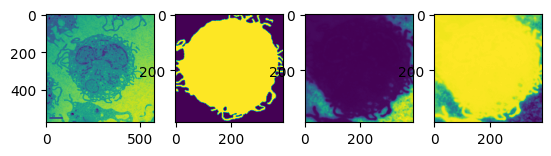

In [107]:

plt.subplot(1, 4, 1), plt.imshow(image[0].cpu().squeeze())
plt.subplot(1, 4, 2), plt.imshow(label[0].cpu().squeeze())
plt.subplot(1, 4, 3), plt.imshow(pred[0][0].cpu().detach().numpy().squeeze())
plt.subplot(1, 4, 4), plt.imshow(pred[0][1].cpu().detach().numpy().squeeze())

In [40]:
#model.eval()
total = 0
correct = 0
total_loss = 0

with torch.no_grad():
  for i, data in enumerate(testloader):
    image, label = data

    #image = image.unsqueeze(1).to(device)
    image = image.to(device)
    label = label.long().to(device)

    pred = model(image)
    label = transforms.CenterCrop(pred.shape[3])(label)
    label = torch.squeeze(label)
    loss = criterion(pred, label)
    
    total_loss += loss.item()

    _, pred_labels = torch.max(pred, dim = 1)
    #print(pred_labels.shape)
    total += label.shape[0] * label.shape[1] * label.shape[2] 
    correct += (pred_labels == label).sum().item()
  #print(correct)
  #print(total)
  print('Accuracy: %.4f ---- Loss: %.4f' % (correct / total, total_loss / testset.__len__()))


Accuracy: 0.7100 ---- Loss: 0.2767


### Testing and Visualization

In [55]:
model.eval()


output_masks = []
output_labels = []
original_images = []
with torch.no_grad():
  for i in range(testset.__len__()):
    image, labels = testset.__getitem__(i)
    original_images.append(image)
    input_image = image.unsqueeze(0).to(device)
    pred = model(input_image)
    #print(pred)
    output_mask = torch.max(pred, dim = 1)[1].cpu().squeeze(0).numpy()
    #print(output_mask.shape)
    '''
    crop_x = (labels.shape[0] - output_mask.shape[0]) // 2
    crop_y = (labels.shape[1] - output_mask.shape[1]) // 2
    labels = labels[crop_x: labels.shape[0] - crop_x, crop_y: labels.shape[1] - crop_y].numpy()
    '''
    labels = transforms.CenterCrop(pred.shape[3])(labels)
    output_masks.append(output_mask)
    output_labels.append(labels)


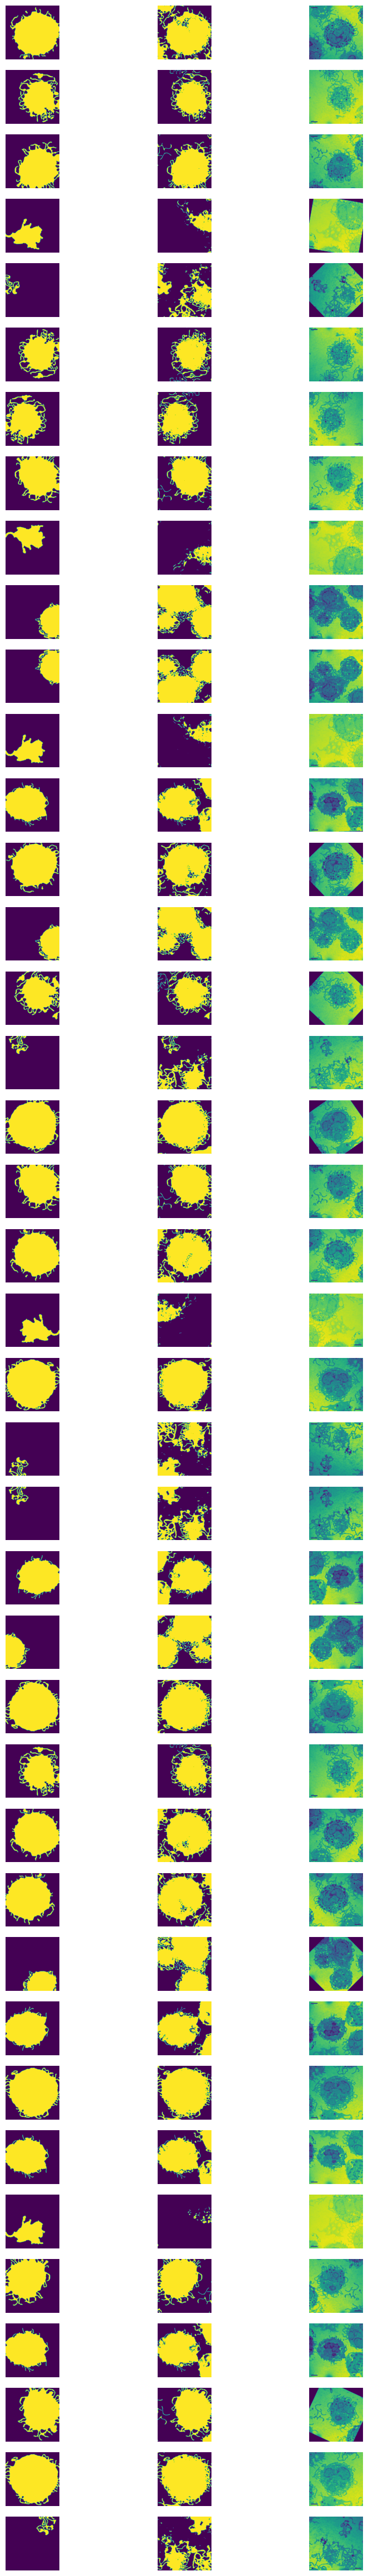

In [56]:
fig, axes = plt.subplots(testset.__len__(), 3, figsize = (10, 60))

for i in range(testset.__len__()):
  output_labels[i] = torch.squeeze(output_labels[i])
  original_images[i] = torch.squeeze(original_images[i])
  #print(output_labels[i])
  axes[i, 0].imshow(output_labels[i])
  axes[i, 0].axis('off')
  axes[i, 1].imshow(output_masks[i])
  axes[i, 1].axis('off')
  axes[i, 2].imshow(original_images[i])
  axes[i, 2].axis('off')